In [125]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
%autoreload 2

from IPython import display
from utils import Logger 

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

In [127]:
data_folder='./pictures'

Preprocess the dataset

In [128]:
img_size = 40

In [129]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

In [130]:
train_set = datasets.ImageFolder('./pictures',data_transforms)

In [131]:
type(train_set[0])

tuple

In [132]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=3, shuffle=True)

In [133]:
num_batches=len(train_loader)

In [134]:
train_loader

In [135]:
x, _ = train_set[3]
x


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

### My Networks

In [421]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features=img_size*img_size
        n_out=1
        
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(1,n_features,2,1,padding=1 ))
        
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1=nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2=nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out=nn.Sequential(
            torch.nn.Linear(256,n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
#         x = self.conv1(x)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        


In [422]:
def images_to_vectors(images):
    return images.view(images.size(0),img_size*img_size)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0),1,img_size,img_size)

In [423]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet,self).__init__()
        n_features=100
        n_out=img_size*img_size
        
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1=nn.Sequential(
            nn.Linear(256,512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2=nn.Sequential(
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out=nn.Sequential(
            nn.Linear(1024,n_out),
            nn.Tanh()
        )
        
    
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    


In [424]:
def noise(size):
    #1-d vector of gaussian sampled random values
    
    n= Variable(torch.randn(size,100))
    #pass to the GPU
    if torch.cuda.is_available(): return n.cuda()
    return n

In [425]:
if torch.cuda.is_available():
    print('available')

available


In [426]:
discriminator = DiscriminatorNet()
generator = GeneratorNet() 

if  torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()


We also need some additional functionality that allows us to create the random noise. The random noise will be sampled from a normal distribution with mean 0 and variance 1

we’ll use Adam as the optimization algorithm for both neural networks

### Optimization

In [427]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)             
                 

The loss function we’ll be using for this task is named Binary Cross Entopy Loss (BCE Loss), and it will be used for this scenario as it resembles the log-loss for both the Generator and Discriminator

In [428]:
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1

# Number of epochs
num_epochs = 200

In [429]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [430]:
def train_discriminator(optimizer , real_data , fake_data):
    
    N = real_data.size(0)
    
    #need to zero gradients
    optimizer.zero_grad()
    
    #train on real data
    prediction_real = discriminator(real_data)
    
    #calculate error and backpropagate
    error_real=loss(prediction_real,real_data_target(N))
    error_real.backward()
    
    #train on fake data
    prediction_fake=discriminator(fake_data)
    error_fake=loss(prediction_fake,fake_data_target(N))
    error_fake.backward()
    
    optimizer.step()
    
    #return error and prdictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

we want to visualize how the training process develops while our GAN learns. To do so, we will create a static batch of noise, every few steps we will visualize the batch of images the generator outputs when using this noise as input

In [431]:
num_test_samples=5
test_noise=noise(num_test_samples)

In [432]:
discriminator

DiscriminatorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=1600, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### Training

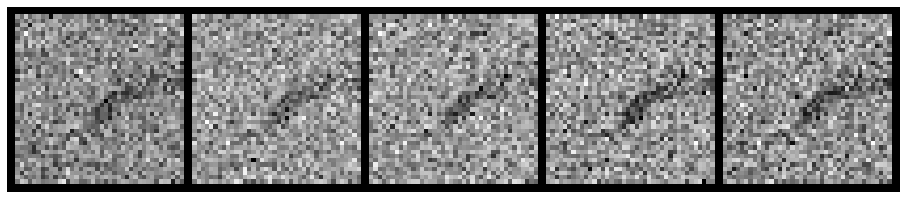

SystemError: <built-in method write of _io.BufferedWriter object at 0x0000025A8C4B5938> returned a result with an error set

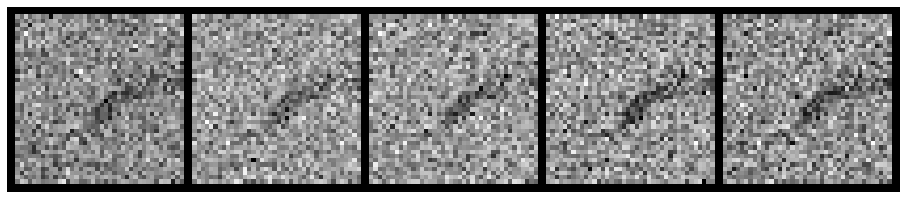

In [434]:
logger = Logger(model_name='sGAN', data_name='domes')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(train_loader):
        print(real_batch.shape)
        #print(real_batch.size(0))
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        #print(real_data.shape)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 3 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

In [405]:
test_images[0].shape

torch.Size([1, 40, 40])

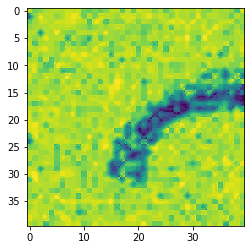

In [149]:
plt.imshow(np.squeeze(test_images[0]))
plt.contour(np.squeeze(test_images[0]))
plt.show()

## Generate lines

In [150]:
img = np.squeeze(test_images[0])
i, j = np.where(img == -1)
img[2,25]

tensor(0.7719)

In [151]:
import trimesh
import shapely
from shapely.geometry import Point, LineString

In [29]:
A = Point(0,0)
B = Point(1,1)
C = Point(1,1,2)
AB = LineString([A, B])

In [30]:
rev = trimesh.creation.revolve(AB,3)

In [31]:
rev.show()

In [32]:
test_images[0].shape

torch.Size([1, 40, 40])

### stupid experiments

In [34]:
arr = torch.randn(3,1,4,4)
print(arr)
print(arr.view(arr.size(0),16))

tensor([[[[-0.8136, -0.0430,  0.8314,  1.8206],
          [ 0.7398,  1.1170, -1.6882,  0.2583],
          [ 0.2788, -1.1651,  0.9624,  0.0708],
          [-2.4689, -0.9783,  0.7292, -0.6227]]],


        [[[-0.4414, -1.2109,  1.1897, -0.5297],
          [-1.9520, -0.0291,  0.4406, -1.2381],
          [-0.7609, -0.9893, -1.3834, -0.8308],
          [ 1.3162,  0.4554,  0.1267,  1.1155]]],


        [[[ 2.0152,  0.1413, -1.5072, -0.7437],
          [ 0.9328,  0.0959,  0.1470, -0.5419],
          [ 0.3676,  0.9275,  1.8061, -1.1312],
          [ 0.3492, -0.5287, -0.0497, -1.4385]]]])
tensor([[-0.8136, -0.0430,  0.8314,  1.8206,  0.7398,  1.1170, -1.6882,  0.2583,
          0.2788, -1.1651,  0.9624,  0.0708, -2.4689, -0.9783,  0.7292, -0.6227],
        [-0.4414, -1.2109,  1.1897, -0.5297, -1.9520, -0.0291,  0.4406, -1.2381,
         -0.7609, -0.9893, -1.3834, -0.8308,  1.3162,  0.4554,  0.1267,  1.1155],
        [ 2.0152,  0.1413, -1.5072, -0.7437,  0.9328,  0.0959,  0.1470, -0.5419,
      

In [35]:
train_set[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 0)

In [36]:
img =np.squeeze(test_images[0])
img.shape

torch.Size([40, 40])

Get contour way 1

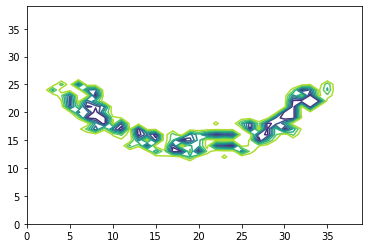

In [37]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


delta = 0.25
x = np.arange(0,28, delta)
y = np.arange(0,28, delta)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()
CS = ax.contour(img)


In [38]:
def get_contour_verts(cn):
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

In [46]:
p=CS.collections[1].get_paths()
len(p)

17

In [63]:
p = CS.collections[1].get_paths()[5]
v = p.vertices
v = v-14

Get contour way 2

In [152]:
from skimage import measure

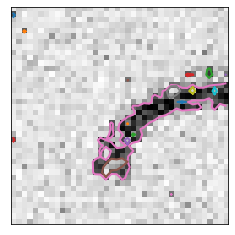

In [198]:
r = img.numpy()
contours = measure.find_contours(r, 0.0001)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [199]:
len(contours)

17

In [64]:
AB = LineString(v)

In [202]:
rev = []
for cn in contours:
    #print (cn.shape)
    rev.append(trimesh.creation.revolve(cn-40))

full_trimesh = rev[0]+rev[1] + rev[2]+rev[3] +rev[4]+rev[5]+rev[6] + rev[7]+rev[8] +rev[9]+rev[10]+ rev[11]+rev[12] +rev[13]+rev[14]+rev[15] + rev[16]

In [203]:
full_trimesh.show()

In [204]:
object = trimesh.exchange.obj.export_obj(full_trimesh)

In [205]:
full_trimesh.export('full_trimesh.obj')

'# https://github.com/mikedh/trimesh\nv 0.00000000 39.00000000 -39.69968657\nv -0.00000000 -39.00000000 -39.69968657\nv 0.00000000 39.26916717 -40.00000000\nv -0.00000000 -38.65664909 -40.00000000\nv 0.00000000 38.65664909 -40.00000000\nv -0.00000000 -39.26916717 -40.00000000\nv 39.00000000 -0.00000000 -39.69968657\nv -39.00000000 -0.00000000 -39.69968657\nv -32.14182903 21.47648354 -40.00000000\nv -32.14182903 -21.47648354 -40.00000000\nv -14.92465386 36.03130177 -39.69968657\nv -14.92465386 -36.03130177 -39.69968657\nv 36.27997981 -15.02765968 -40.00000000\nv 36.27997981 15.02765968 -40.00000000\nv -38.51462113 -7.66103447 -40.00000000\nv -38.51462113 7.66103447 -40.00000000\nv 7.60852256 -38.25062594 -39.69968657\nv 7.60852256 38.25062594 -39.69968657\nv -32.42731488 21.66723909 -39.69968657\nv -32.42731488 -21.66723909 -39.69968657\nv -27.57716447 -27.57716447 -39.69968657\nv -27.57716447 27.57716447 -39.69968657\nv -14.79325916 35.71408689 -40.00000000\nv -14.79325916 -35.71408689

In [453]:
Z = (torch.Tensor(2, 2)) #.normal_(0, 0.33))
print(Z)
y=Z.normal_()
y

tensor([[9.2755e-39, 1.0561e-38],
        [5.9694e-39, 9.2755e-39]])


tensor([[-1.5001,  1.0268],
        [ 0.3337, -1.4817]])

In [441]:
batch_size=3
z_dim=100